In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pymc as pm
import arviz as az
import xarray as xr
from sklearn.preprocessing import StandardScaler
import statsmodels.graphics.tsaplots as smg
import pytensor
import pytensor.tensor as pt
from pymc.pytensorf import collect_default_updates
import pandas as pd
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

from pymc.pytensorf import collect_default_updates

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%config InlineBackend.figure_format = "retina"

# rng = np.random.default_rng(42)


Time series derived from a generative graph.

Main advantage over packaged methods is flexibity:
     Different noise distributions (StudentT noise)
     Exponential smoothing models
     ARIMA-GARCH models




In [2]:
# get data     
data = pd.read_csv(r"../data/a0_combinedQuarterly_new.csv", index_col=[0])
data = data['gdp_total_season'].to_frame()
data['gdp_total_season_diff'] = data['gdp_total_season'].diff()
data.dropna(inplace=True)


### Standardize

            gdp_total_season_stdz  gdp_total_season_diff_stdz
1995-04-01               116624.0                   -0.103615
1995-07-01               114315.0                   -0.445386
1995-10-01               121939.0                    1.033835
1996-01-01               119460.0                   -0.470702
1996-04-01               121240.0                    0.163547
...                           ...                         ...
2023-01-01               197186.0                   -1.656701
2023-04-01               206848.0                    1.337334
2023-07-01               196434.0                   -1.652382
2023-10-01               206850.0                    1.449620
2024-01-01               195724.0                   -1.758413

[116 rows x 2 columns]


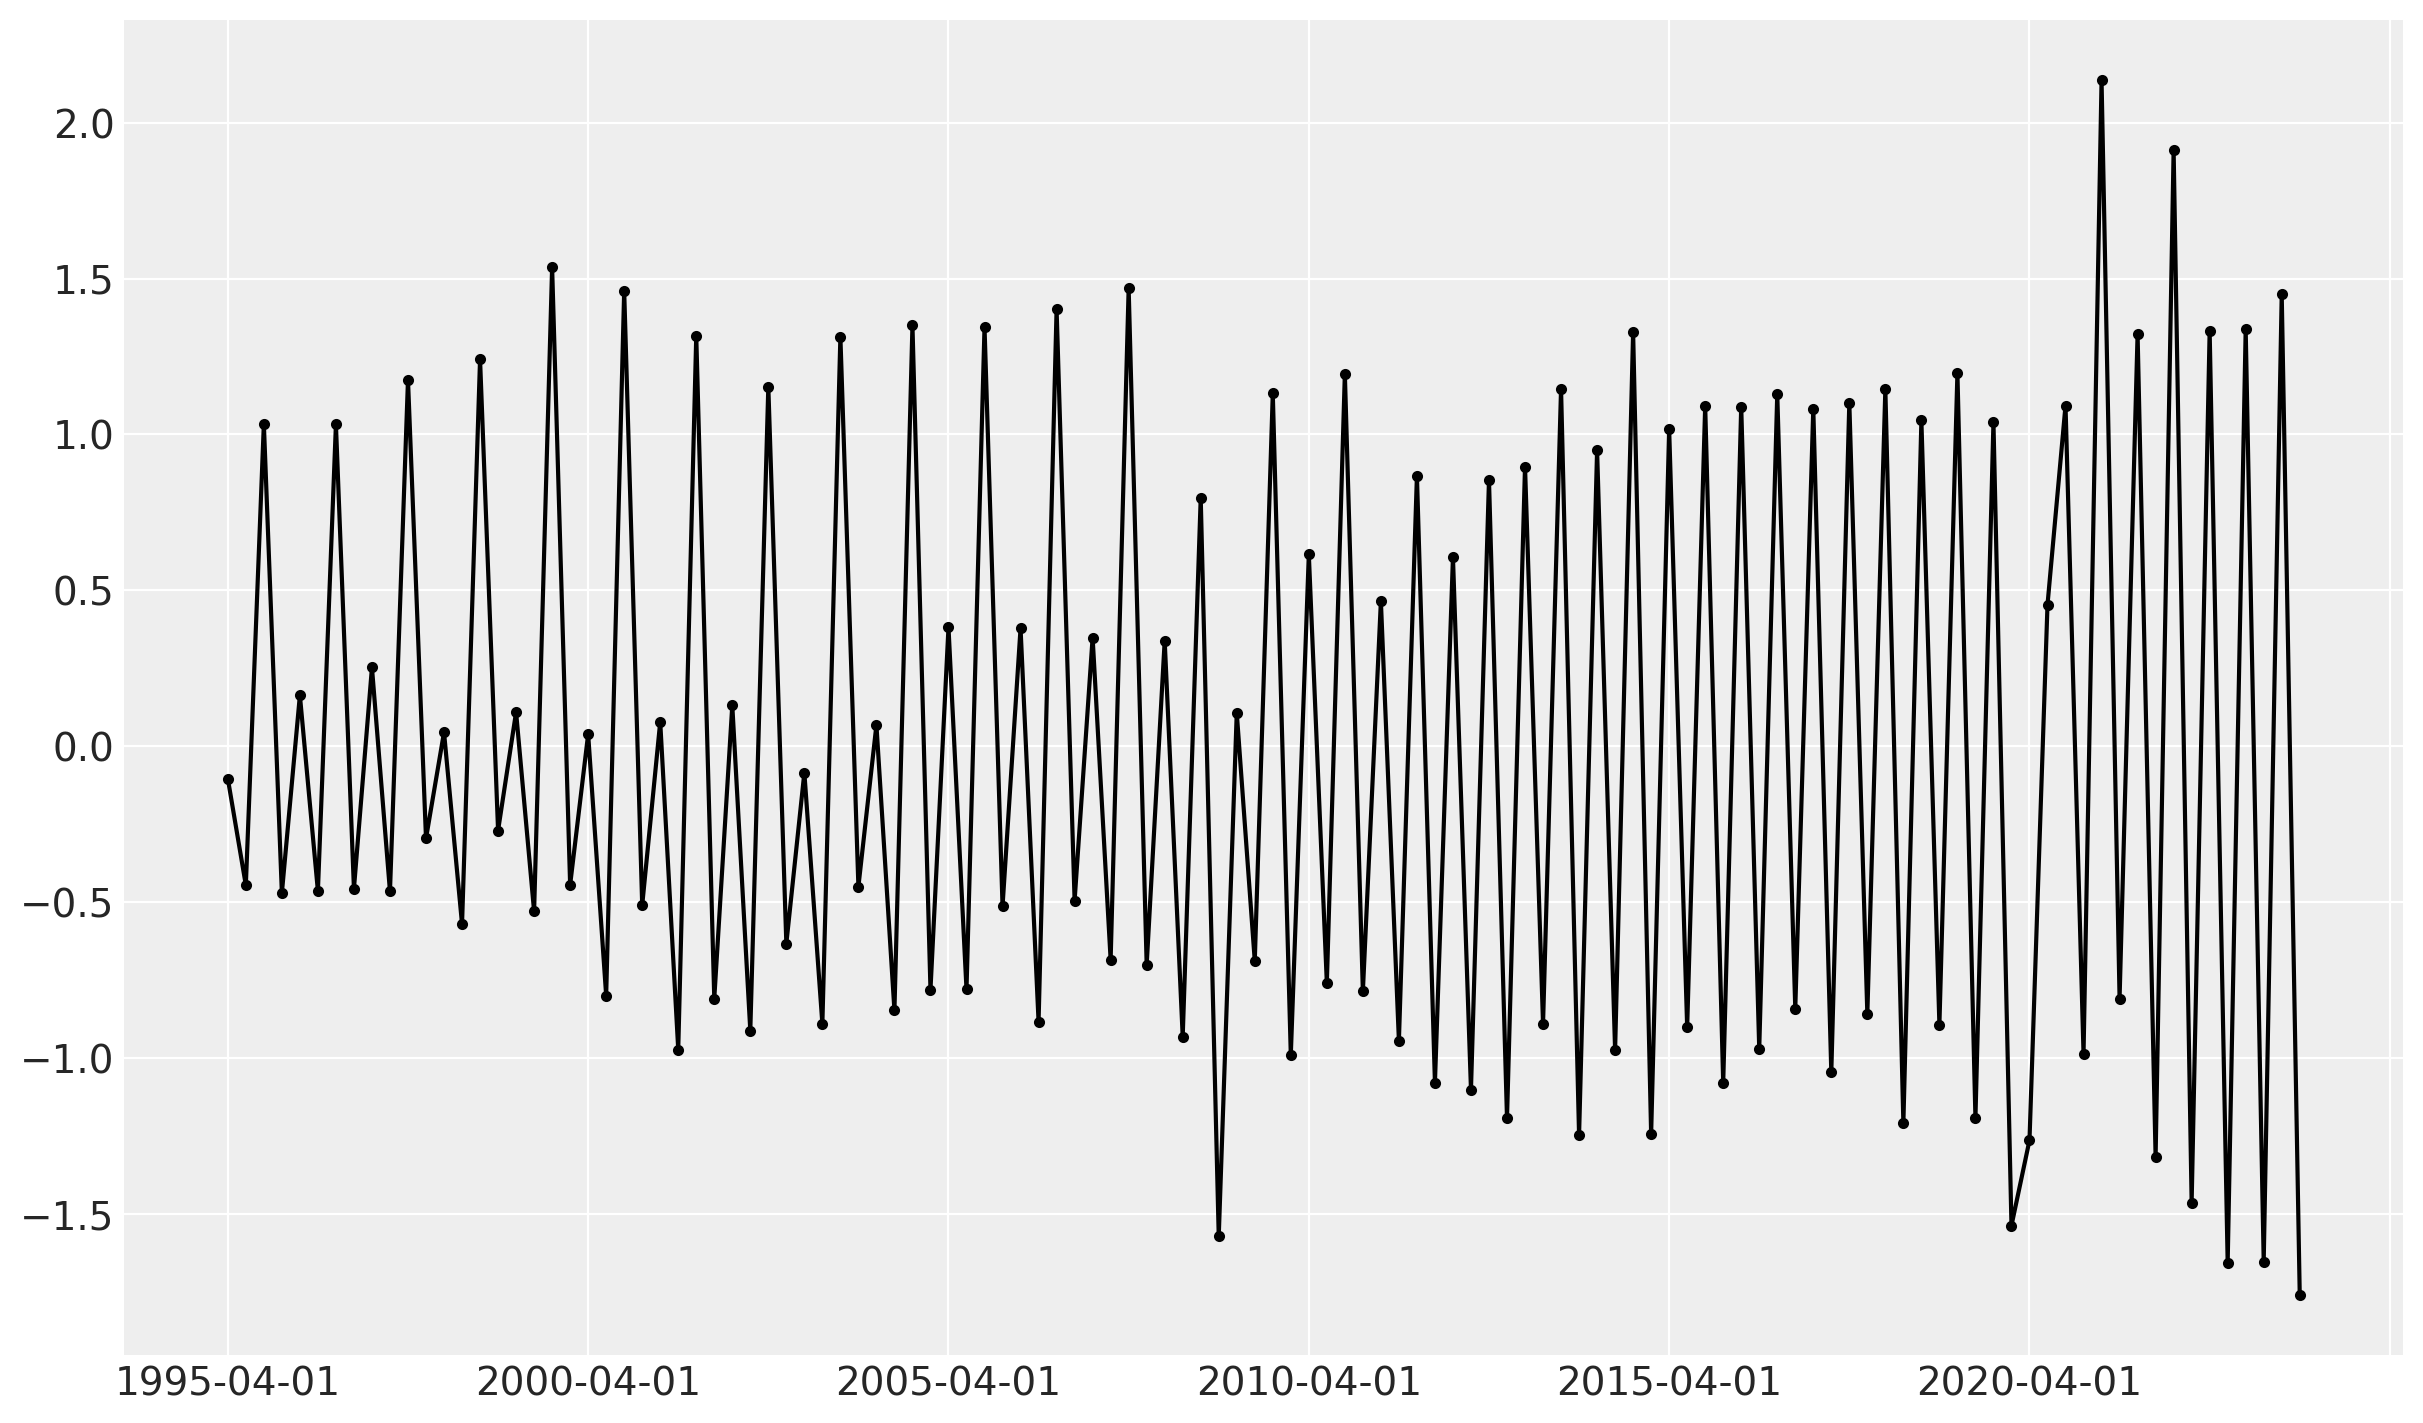

In [3]:
scaler = StandardScaler()

columns_Transform = ["gdp_total_season_diff"]
data[columns_Transform] = scaler.fit_transform(data[columns_Transform])
data.columns = [cls + "_stdz" for cls in data.columns]
data['gdp_total_season_diff_stdz'].plot(style=".-", color="k");

y = data

print(y)

In [4]:
data = pd.read_csv(r"../data/a0_combinedQuarterly_new.csv", index_col=[0])
data = data['gdp_total_season'].to_frame()

diff_data =  data['gdp_total_season'].diff()
std1 = diff_data.std()
mean1 = diff_data.mean()

$$
y_t = \rho_0 + \rho_1 y_{t-1} + \rho_2 y_{t-2} + \epsilon_t 
$$


#### A "for" loop is necessary as can be seen by interating an AR1 backwards k times we get: 
$
\\
y_t = \rho y_{t-1} + \epsilon_t \\
y_{t-1} = \rho y_{t-2} + \epsilon_{t-1} \\
y_{t-2} = \rho y_{t-3} + \epsilon_{t-2} \\
y_{t-k} = \rho y_{t-(k-1)} + \epsilon_{t-k}  \\
\vdots \\
y_t = \rho^k y_{t-k} + \sum_{j=0}^{k-1} \rho^j \epsilon_{t-j}
$

######################################################################################

## Defining AR2 model in PyMC with Scan

In [5]:
# https://gist.github.com/ricardoV94/a49b2cc1cf0f32a5f6dc31d6856ccb63#file-pymc_timeseries_ma-ipynb

# seed = sum(map(ord, "GDP+AR(2)"))
# rng = np.random.default_rng(seed)

In [6]:


# This is the transition function for the AR(2) model.
# We take as inputs previous steps and then specify the autoregressive relationship.
# Finally, we add Gaussian noise to the model.
def ar_step(x_tm2, x_tm1, rho, sigma):
    mu = x_tm1 * rho[0] + x_tm2 * rho[1]
    x = mu + pm.Normal.dist(sigma=sigma)
    return x, collect_default_updates([x])                            # tells PyMC that the RV in the generative graph should be updated in evey interation of the loop.

# Here we actually "loop" over the time series.
def ar_dist(ar_init, rho, sigma, size):
    ar_innov, _ = pytensor.scan(
        fn=ar_step,
        outputs_info=[{"initial": ar_init, "taps": range(-lags, 0)}], # list or dictionary describing the initial state of the outputs computed recurrently. "taps" specifies the number of previous time steps to keep track of.
        non_sequences=[rho, sigma],                                   # arguments passed to the function at each step
        n_steps=timeseries_length - lags, 
        strict=True,                                                  # all variables must be provided as either non_sequences or sequences
    )

    return ar_innov



In [7]:
y = y['gdp_total_season_diff_stdz']
timeseries_length  = 116
lags = 2

coords = {
    "lags": range(-lags, 0),
    "steps": range(timeseries_length - lags),
    "timeseries_length": range(timeseries_length),
}

with pm.Model(coords=coords, check_bounds=False) as m:
    
    rho = pm.Normal("rho", mu=0, sigma=0.20, dims=("lags",)) #number of lags, lags defined in coords
    sigma = pm.HalfNormal("sigma", sigma=0.20)
    
    ar_init = pm.Normal("ar_init", sigma=0.50, dims=("lags",))

    ar_innov = pm.CustomDist(
        "ar_dist",
        ar_init,
        rho, 
        sigma,
        dist=ar_dist,
        dims=("steps",)
    )
        
    ar = pm.Deterministic("ar", pt.concatenate([ar_init, ar_innov], axis=-1), dims=("timeseries_length",)) #innovations being added each step

In [8]:
#pm.model_to_graphviz(m)

In [9]:
with m:
    prior = pm.sample_prior_predictive(samples=500)

Sampling: [ar_dist, ar_init, rho, sigma]


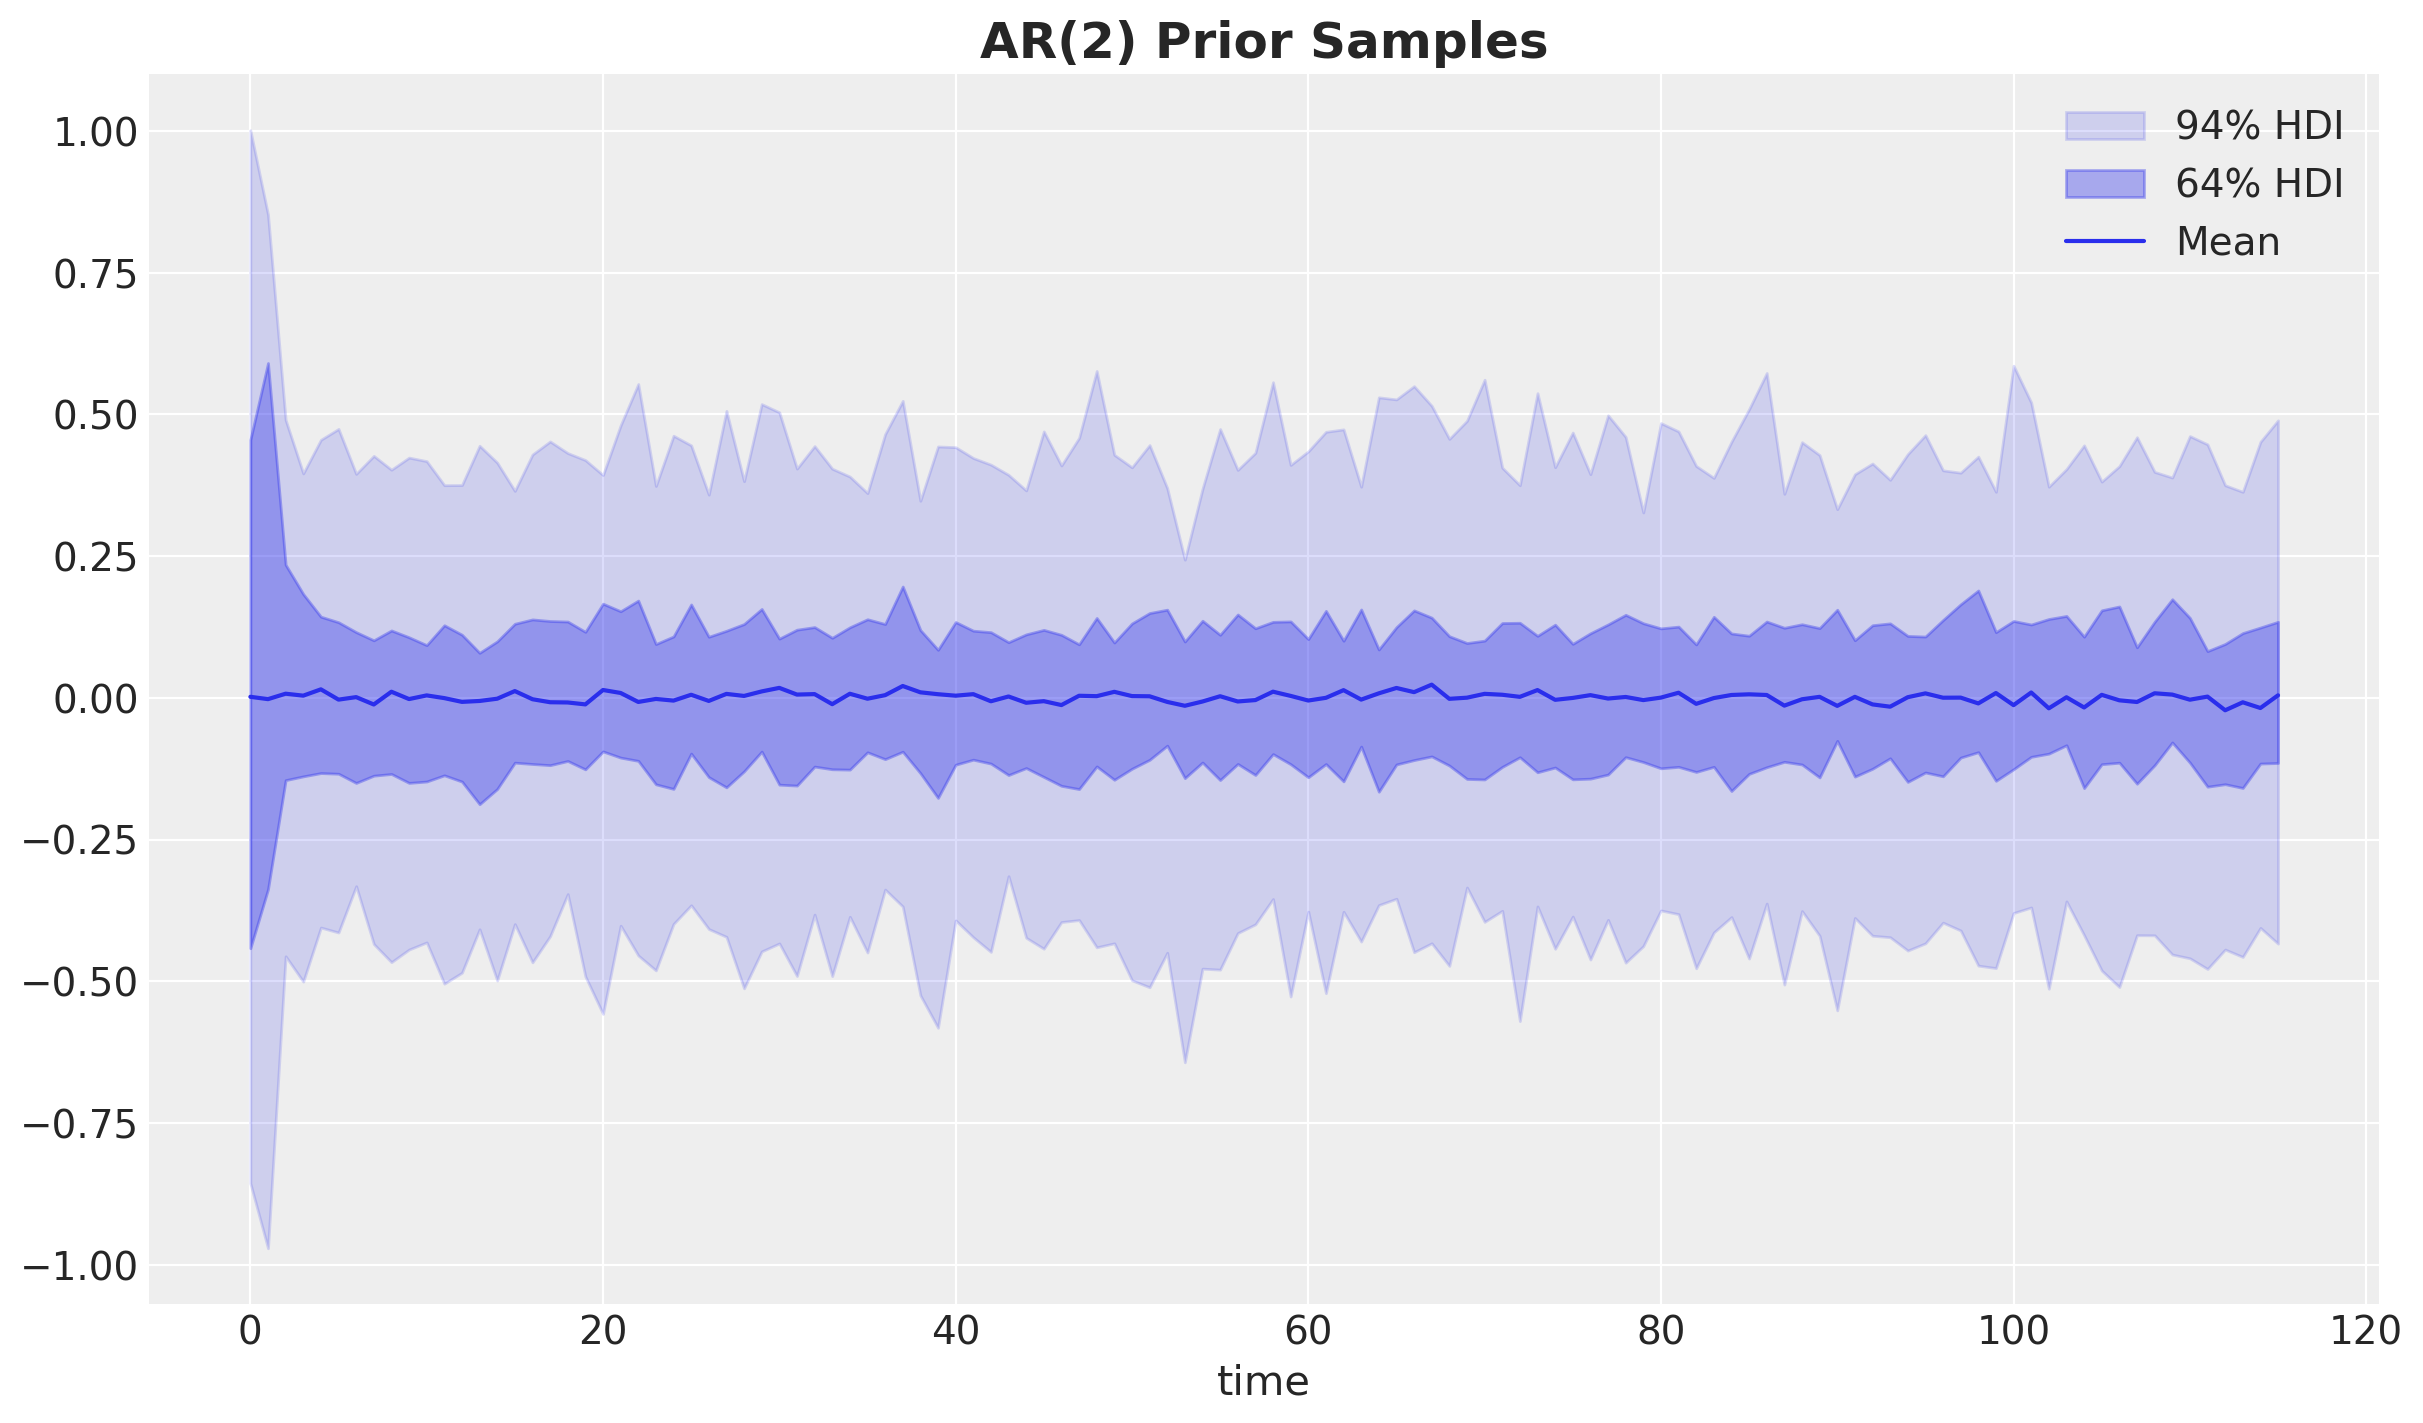

In [10]:
_, ax = plt.subplots()
for i, hdi_prob in enumerate((0.94, 0.64), 1):
    hdi = az.hdi(prior.prior["ar"], hdi_prob=hdi_prob)["ar"]
    lower = hdi.sel(hdi="lower")
    upper = hdi.sel(hdi="higher")
    ax.fill_between(
        x=np.arange(timeseries_length),
        y1=lower,
        y2=upper,
        alpha=(i - 0.2) * 0.2,
        color="C0",
        label=f"{hdi_prob:.0%} HDI",
    )
ax.plot(prior.prior["ar"].mean(("chain", "draw")), color="C0", label="Mean")
ax.legend(loc="upper right")
ax.set_xlabel("time")
ax.set_title("AR(2) Prior Samples", fontsize=18, fontweight="bold");

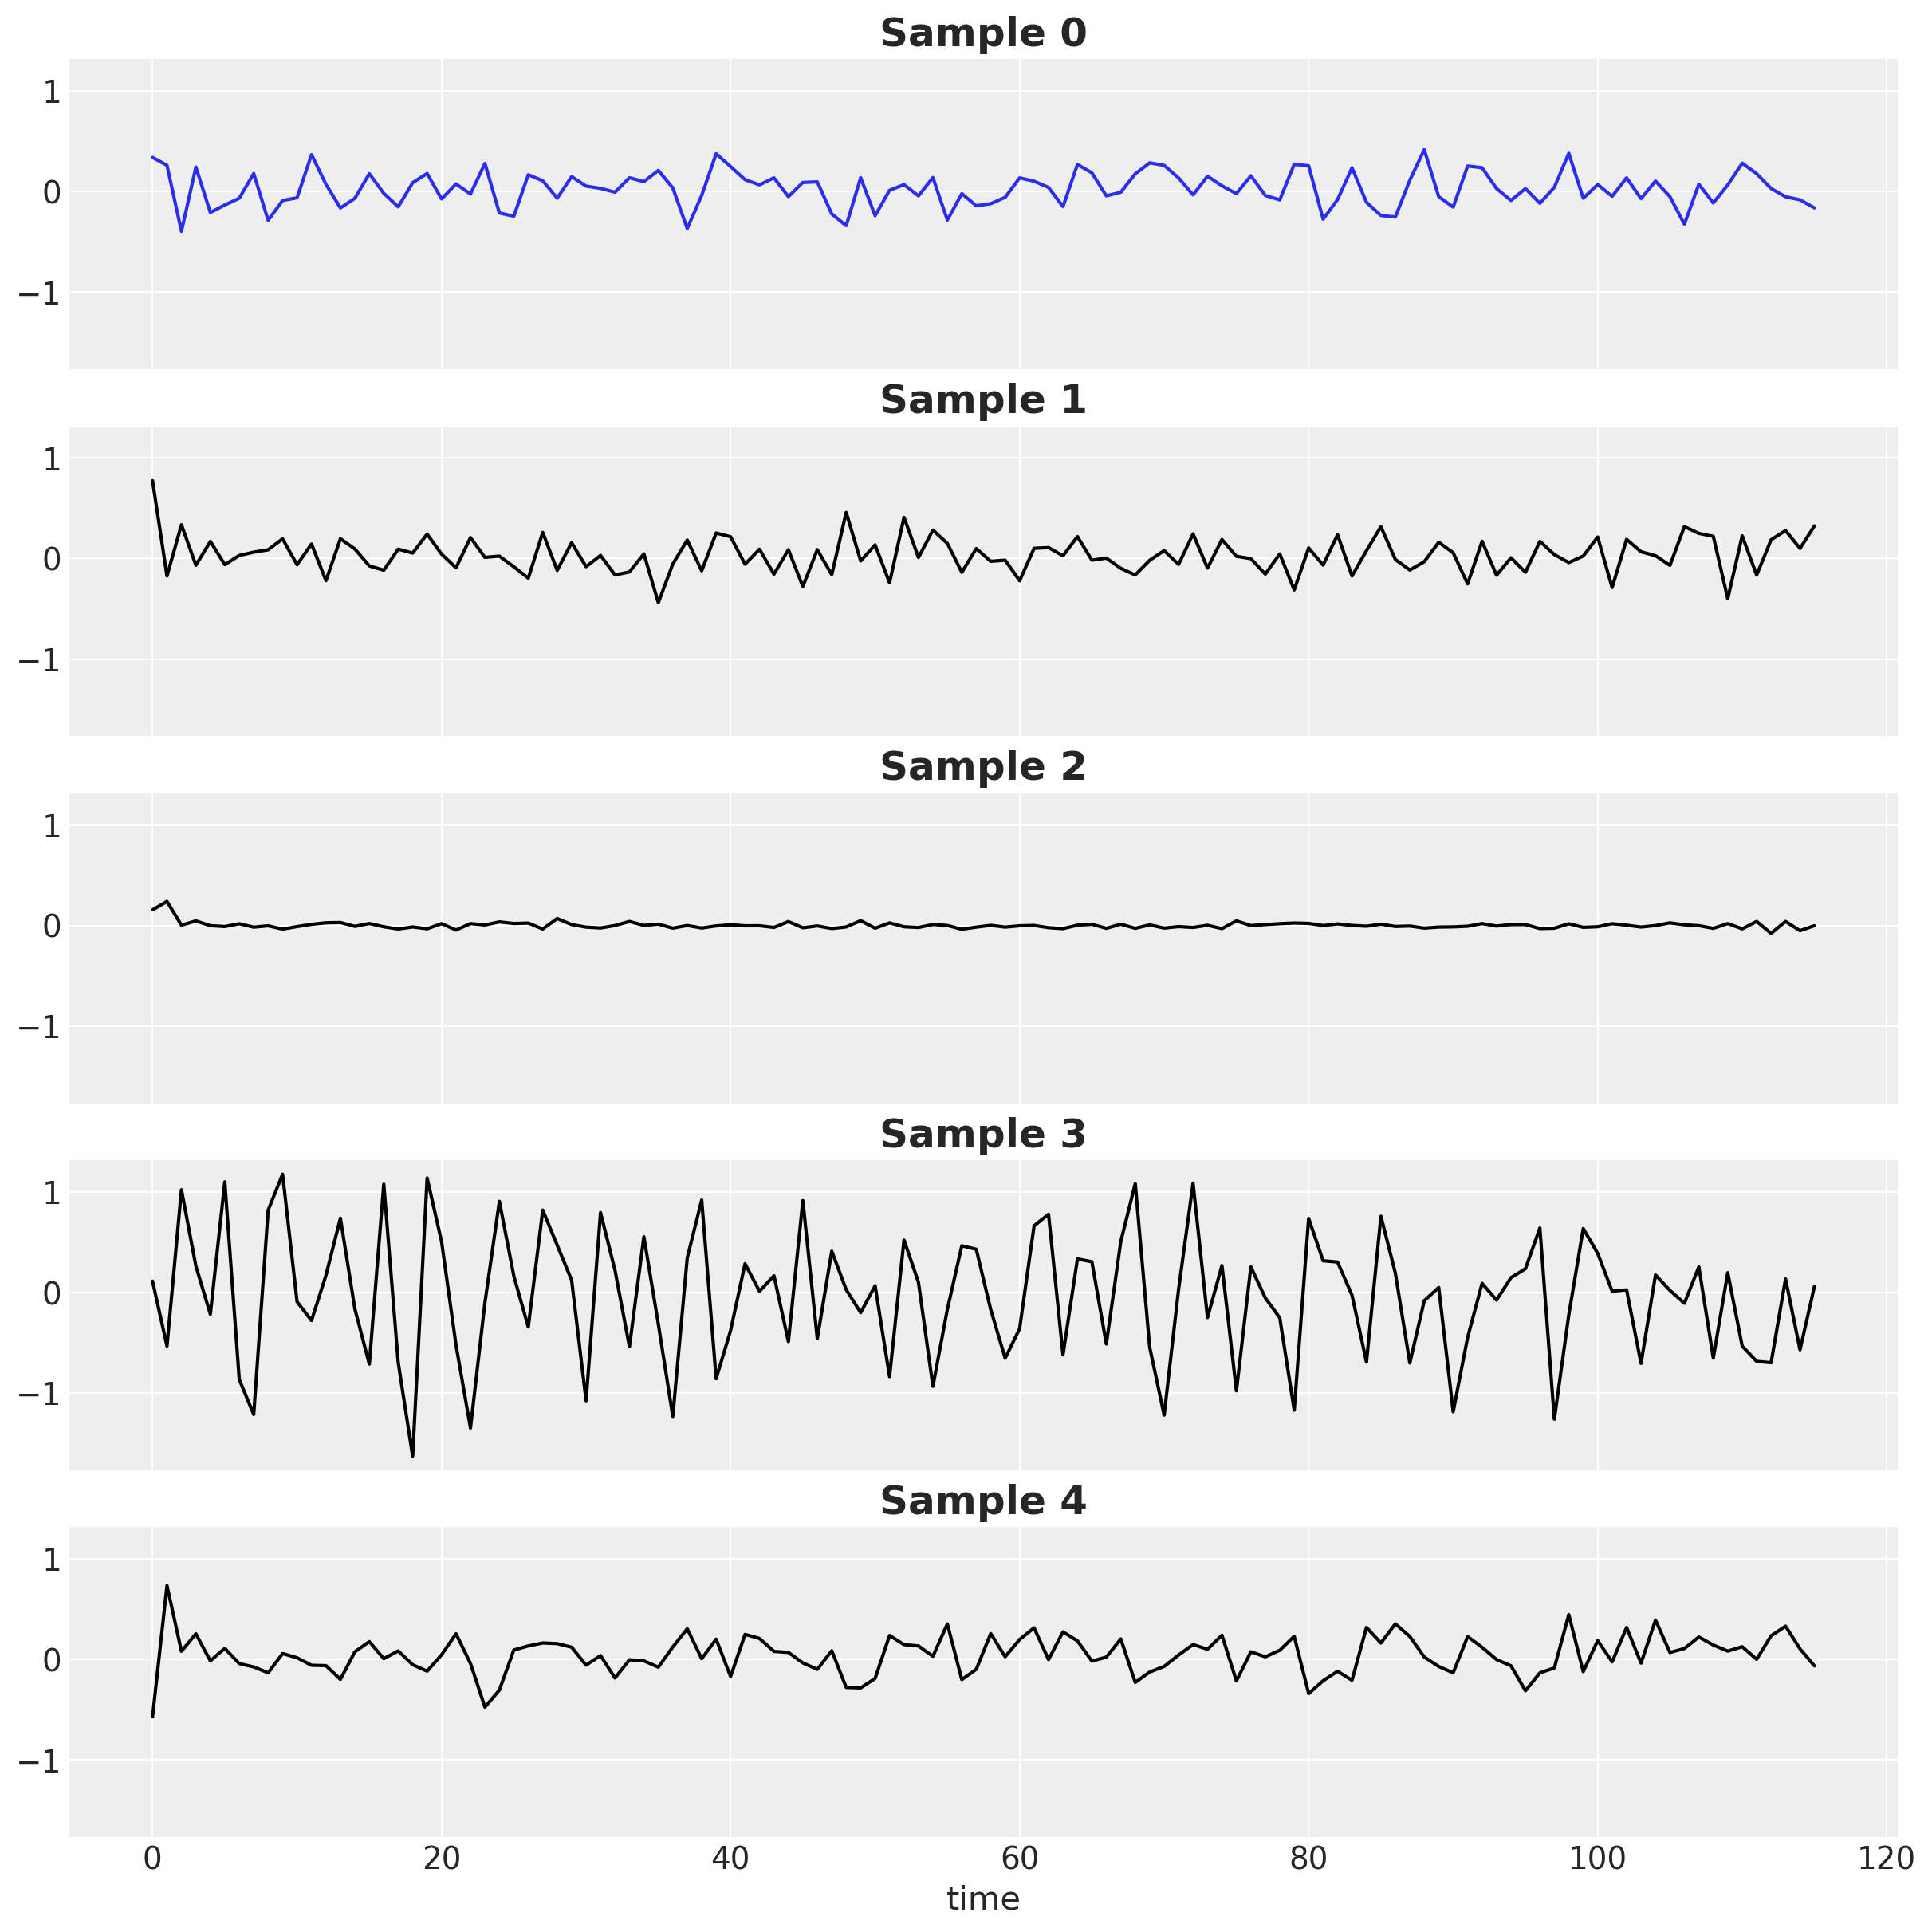

In [11]:
fig, ax = plt.subplots(
    nrows=5, ncols=1, figsize=(12, 12), sharex=True, sharey=True, layout="constrained"
)
chosen_draw = 0

for i, axi in enumerate(ax, start=chosen_draw):
    axi.plot(
        prior.prior["ar"].isel(draw=i, chain=0),
        color="C0" if i == chosen_draw else "black",
    )
    axi.set_title(f"Sample {i}", fontsize=18, fontweight="bold")
ax[-1].set_xlabel("time");

## Posterior

In [12]:
# select a random draw from the prior
prior_draw = prior.prior.isel(chain=0, draw=chosen_draw)
test_data = prior_draw["ar_dist"].to_numpy()

with pm.observe(m, {"ar_dist": test_data}) as observed_model:
    trace = pm.sample(chains=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma, ar_init]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.


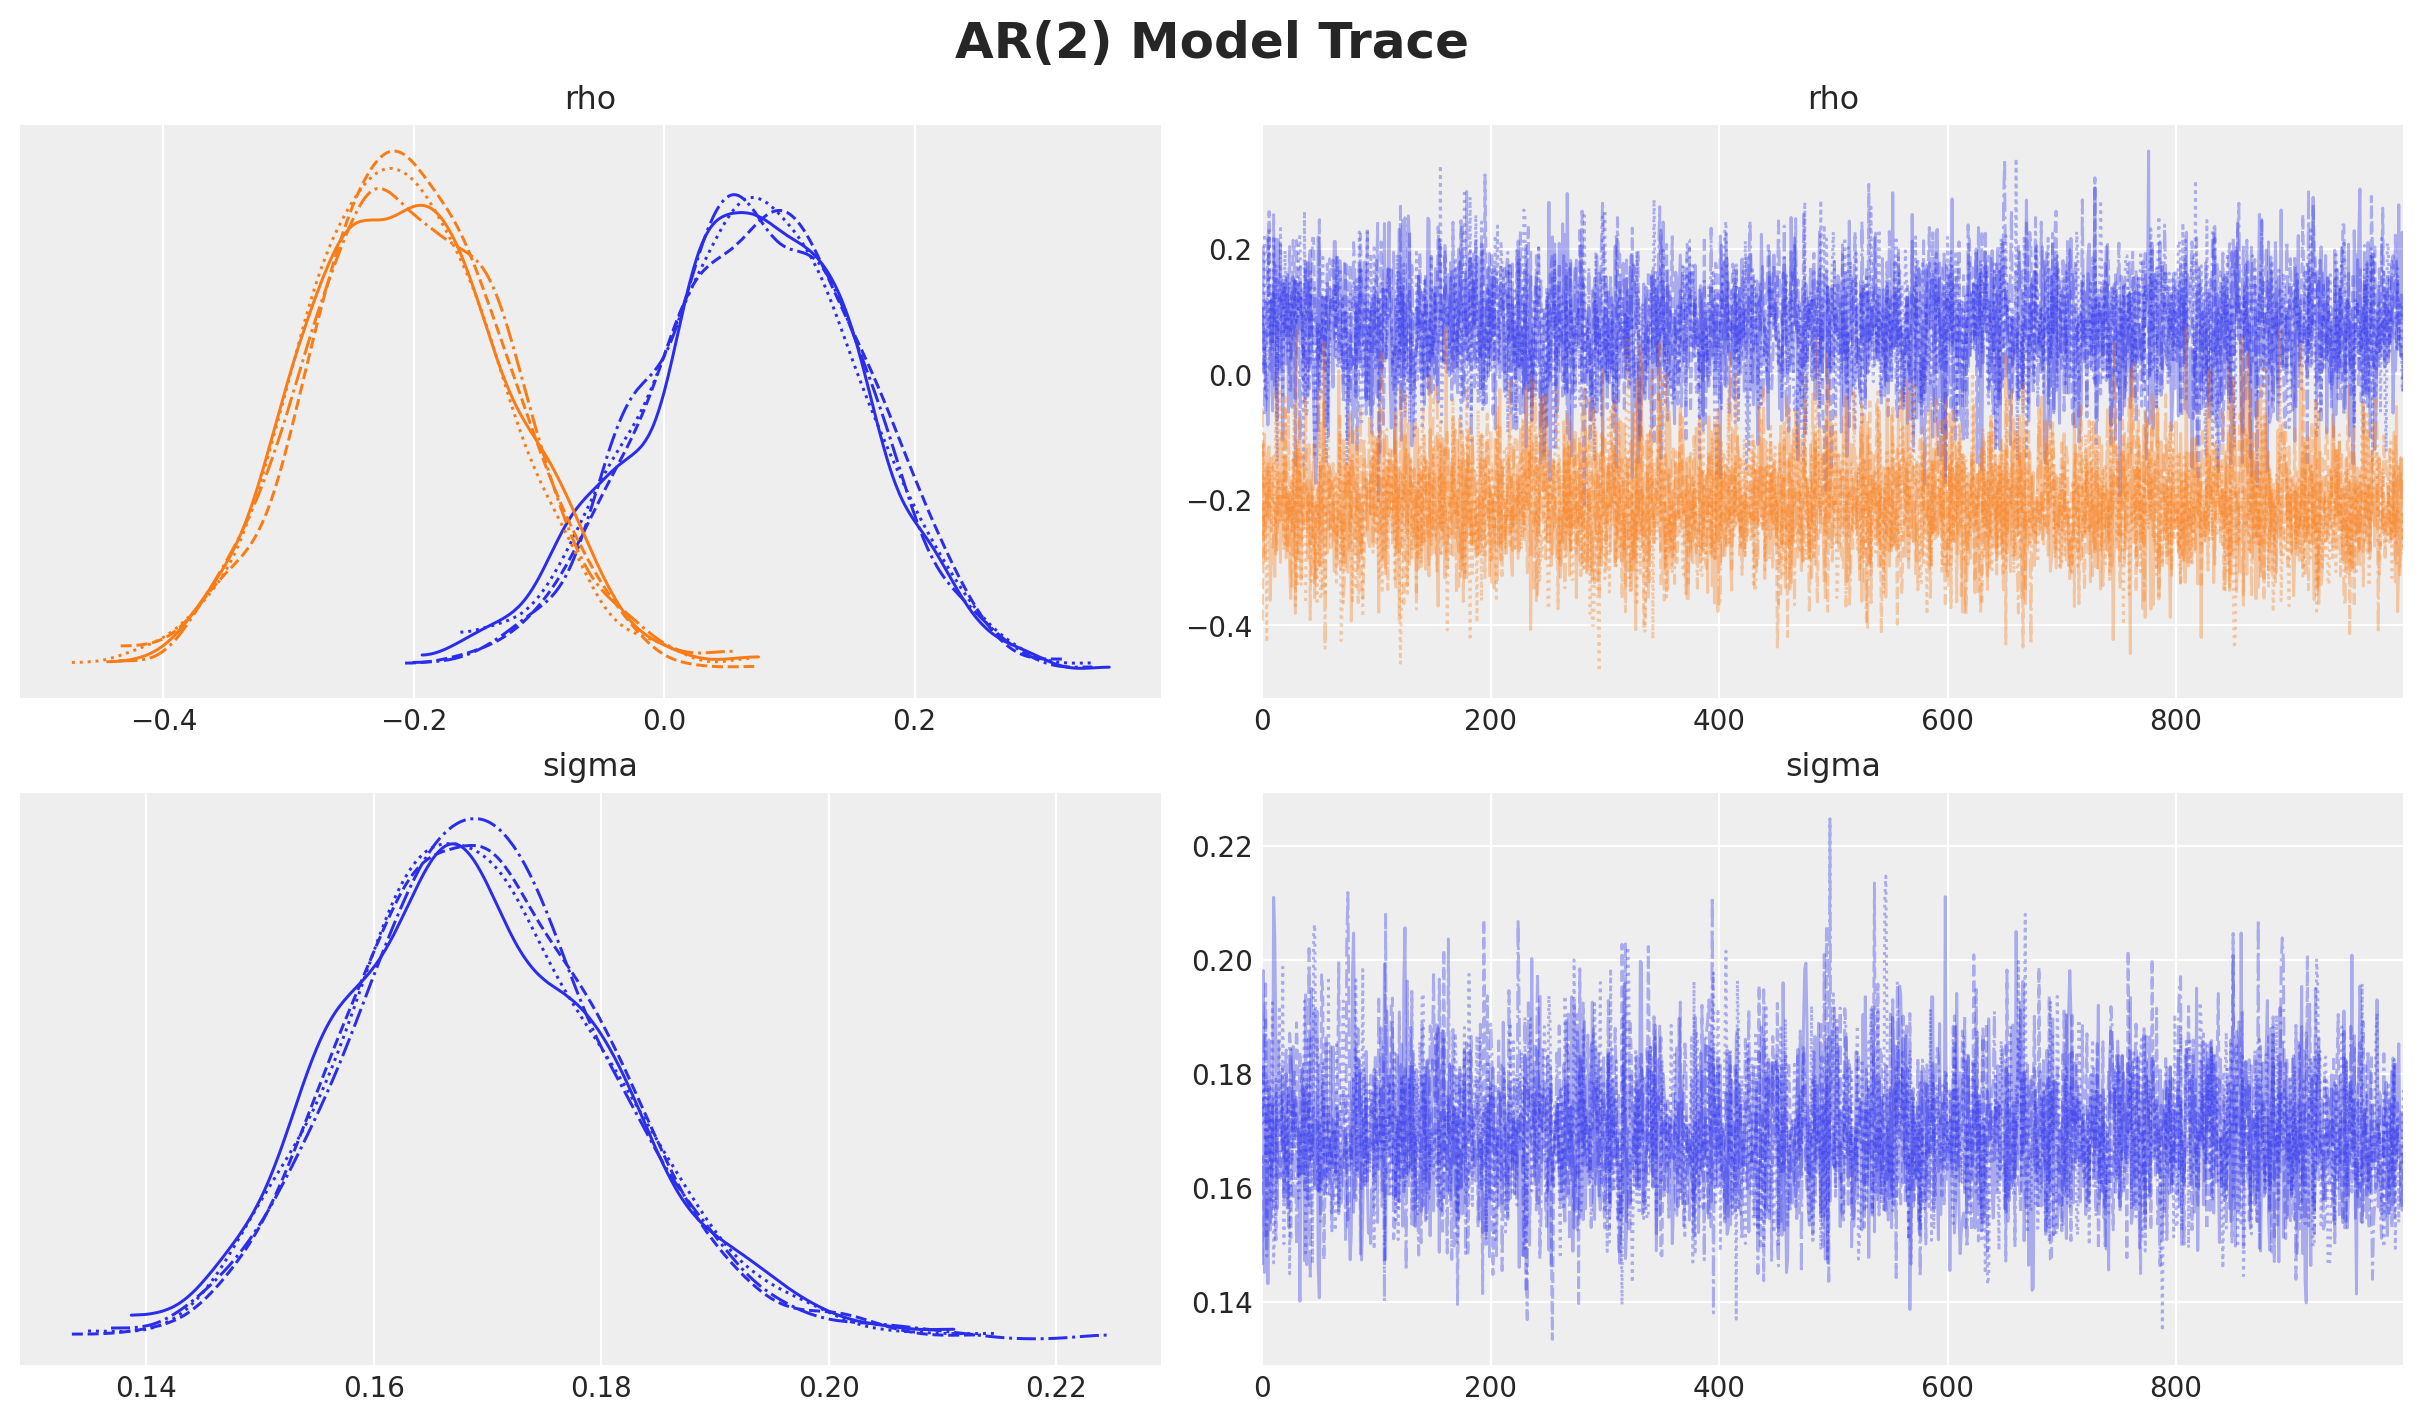

In [13]:
# Get the true values of the parameters from the prior draw
ar_obs = y

axes = az.plot_trace(
    data=trace,
    var_names=["rho", "sigma"],
    compact=True,
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("AR(2) Model Trace", fontsize=18, fontweight="bold");

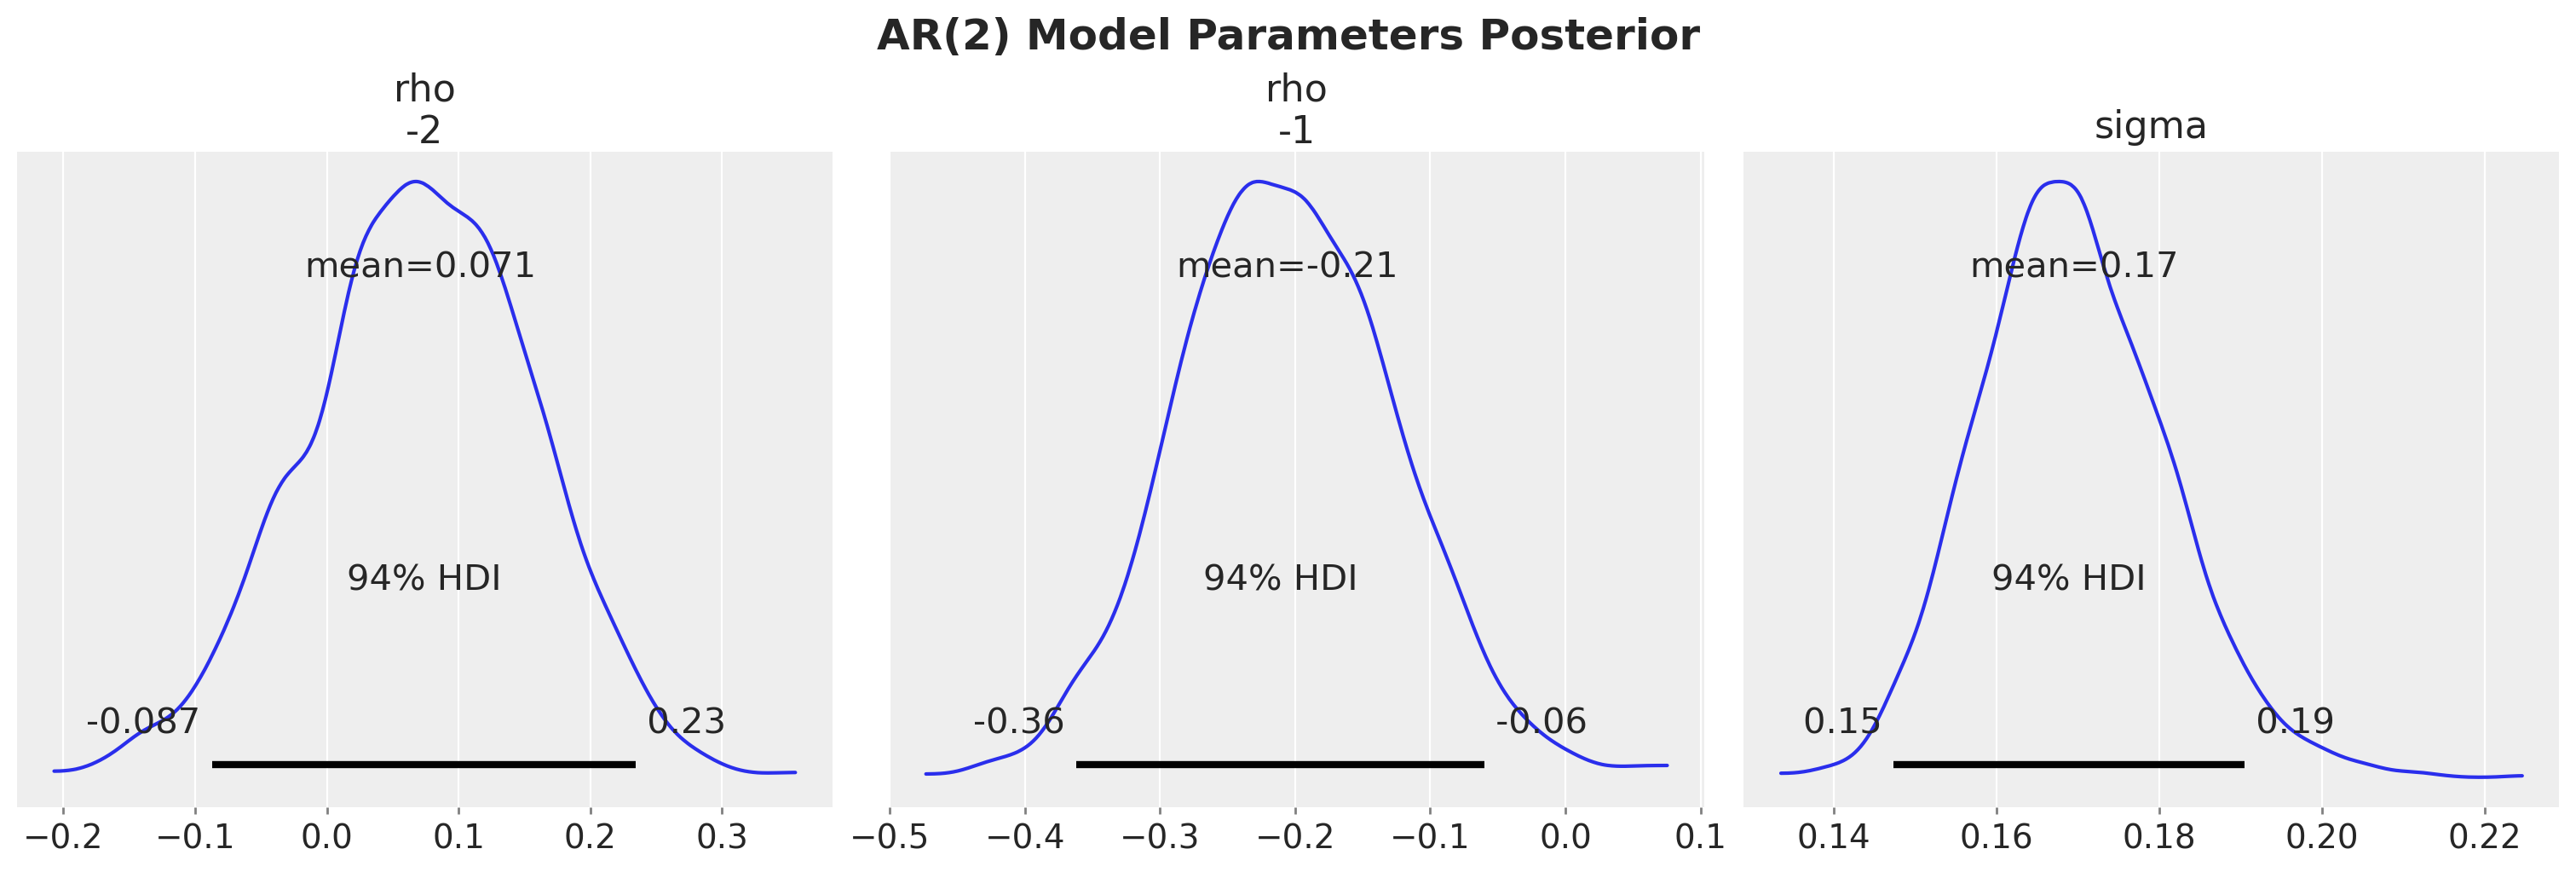

In [14]:
axes = az.plot_posterior(
    trace, var_names=["rho", "sigma"], figsize=(15, 5)
)
plt.gcf().suptitle("AR(2) Model Parameters Posterior", fontsize=18, fontweight="bold");

## Posterior Predictive

In [15]:
with m:
    post_pred = pm.sample_posterior_predictive(trace)

In [16]:
post_pred_ar = post_pred.posterior_predictive["ar"]

_, ax = plt.subplots()
for i, hdi_prob in enumerate((0.94, 0.64), 1):
    hdi = az.hdi(post_pred_ar, hdi_prob=hdi_prob)["ar"]
    lower = hdi.sel(hdi="lower")
    upper = hdi.sel(hdi="higher")
    ax.fill_between(
        x=post_pred_ar["timeseries_length"],
        y1=lower,
        y2=upper,
        alpha=(i - 0.2) * 0.2,
        color="C0",
        label=f"{hdi_prob:.0%} HDI",
    )
ax.plot(
    post_pred_ar["timeseries_length"],
    post_pred_ar.mean(("chain", "draw")),
    color="C0",
    label="Mean",
)
ax.plot(ar_obs, color="black", label="Observed")
ax.legend(loc="upper right")
ax.set_xlabel("time")
ax.set_title("AR(2) Posterior Predictive Samples", fontsize=18, fontweight="bold");

AttributeError: 'InferenceData' object has no attribute 'posterior_predictive'

In [ ]:
fig, ax = plt.subplots(
    nrows=5, ncols=1, figsize=(12, 12), sharex=True, sharey=True, layout="constrained"
)
for i, axi in enumerate(ax):
    axi.plot(post_pred.posterior_predictive["ar"].isel(draw=i, chain=0), color="C0")
    axi.plot(ar_obs, color="black", label="Observed")
    axi.legend(loc="upper right")
    axi.set_title(f"Sample {i}")

ax[-1].set_xlabel("time")

fig.suptitle("AR(2) Posterior Predictive Samples", fontsize=18, fontweight="bold", y=1.05);

In [63]:
def conditional_ar_dist(y_data, rho, sigma, size):
    # Here we condition on the observed data by passing it through the `sequences` argument.
    ar_innov, _ = pytensor.scan(
        fn=ar_step,
        sequences=[{"input": y_data, "taps": list(range(-lags, 0))}],
        non_sequences=[rho, sigma],
        n_steps=timeseries_length - lags,
        strict=True,
    )

    return ar_innov

In [ ]:
coords = {
    "lags": range(-lags, 0),
    "steps": range(-1, timeseries_length - lags - 1),  # <- Coordinate shift!
    "timeseries_length": range(1, timeseries_length + 1),  # <- Coordinate shift!
}
with pm.Model(coords=coords, check_bounds=False) as conditional_model:
    y_data = pm.Data("y_data", y)
    rho = pm.Normal(name="rho", mu=0, sigma=0.2, dims=("lags",))
    sigma = pm.Normal(name="sigma", sigma=0.2)

    ar_innov = pm.CustomDist(
        "ar_innov",
        y_data,
        rho,
        sigma,
        dist=conditional_ar_dist,
        dims=("steps",),
    )

    ar = pm.Deterministic(
        name="ar", var=pt.concatenate([ar_init, ar_innov], axis=-1), dims=("timeseries_length",)
    )

    post_pred_conditional = pm.sample_posterior_predictive(trace, var_names=["ar"])

In [ ]:
# PyMC conditional posterior predictive samples

#conditional_post_pred_ar = post_pred_conditional.posterior_predictive["ar"]

# Statsmodels AR(2) model
mod = sm.tsa.ARIMA(y, order=(2, 0, 0), trend="c")
res = mod.fit()
res.summary()

In [ ]:
_, ax = plt.subplots()
for i, hdi_prob in enumerate((0.94, 0.64), 1):
    hdi = az.hdi(conditional_post_pred_ar, hdi_prob=hdi_prob)["ar"]
    lower = hdi.sel(hdi="lower")
    upper = hdi.sel(hdi="higher")
    ax.fill_between(
        x=conditional_post_pred_ar["timeseries_length"],
        y1=lower,
        y2=upper,
        alpha=(i - 0.2) * 0.2,
        color="C1",
        label=f"{hdi_prob:.0%} HDI",
    )
ax.plot(
    conditional_post_pred_ar["timeseries_length"],
    conditional_post_pred_ar.mean(("chain", "draw")),
    color="C1",
    label="Mean",
)
ax.plot(y, color="black", label="Observed")
ax.plot(
    conditional_post_pred_ar["timeseries_length"],
    res.fittedvalues,
    color="C2",
    label="statsmodels",
)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=5)
ax.set_xlabel("time")
ax.set_title("AR(2) Conditional Posterior Predictive Samples", fontsize=18, fontweight="bold");

## Out of Sample Predictions

In [67]:
# Specify the number of steps to forecast
forecast_steps = 10

In [ ]:
coords = {
    "lags": range(-lags, 0),
    "steps": range(timeseries_length, timeseries_length + forecast_steps),
}
with pm.Model(coords=coords, check_bounds=False) as forecasting_model:
    forecast_initial_state = pm.Data("forecast_initial_state", ar_obs[-lags:], dims=("lags",))
    rho = pm.Flat(name="rho", dims=("lags",))
    sigma = pm.Flat(name="sigma")

    def ar_dist_forecasting(forecast_initial_state, rho, sigma, size):
        ar_innov, _ = pytensor.scan(
            fn=ar_step,
            outputs_info=[{"initial": forecast_initial_state, "taps": range(-lags, 0)}],
            non_sequences=[rho, sigma],
            n_steps=forecast_steps,
            strict=True,
        )
        return ar_innov

    ar_innov = pm.CustomDist(
        "ar_dist",
        forecast_initial_state,
        rho,
        sigma,
        dist=ar_dist_forecasting,
        dims=("steps",),
    )

    post_pred_forecast = pm.sample_posterior_predictive(
        trace, var_names=["ar_dist"]
    )

In [ ]:
forecast_post_pred_ar = post_pred_forecast.posterior_predictive["ar_dist"]

_, ax = plt.subplots()
for i, hdi_prob in enumerate((0.94, 0.64), 1):
    hdi = az.hdi(conditional_post_pred_ar, hdi_prob=hdi_prob)["ar"]
    lower = hdi.sel(hdi="lower")
    upper = hdi.sel(hdi="higher")
    ax.fill_between(
        x=conditional_post_pred_ar["timeseries_length"],
        y1=lower,
        y2=upper,
        alpha=(i - 0.2) * 0.2,
        color="C1",
        label=f"{hdi_prob:.0%} HDI",
    )

ax.plot(
    conditional_post_pred_ar["timeseries_length"],
    conditional_post_pred_ar.mean(("chain", "draw")),
    color="C1",
    label="Mean",
)

for i, hdi_prob in enumerate((0.94, 0.64), 1):
    hdi = az.hdi(forecast_post_pred_ar, hdi_prob=hdi_prob)["ar_dist"]
    lower = hdi.sel(hdi="lower")
    upper = hdi.sel(hdi="higher")
    ax.fill_between(
        x=forecast_post_pred_ar["steps"],
        y1=lower,
        y2=upper,
        alpha=(i - 0.2) * 0.2,
        color="C3",
        label=f"{hdi_prob:.0%} HDI forecast",
    )

ax.plot(
    forecast_post_pred_ar["steps"],
    forecast_post_pred_ar.mean(("chain", "draw")),
    color="C3",
    label="Mean Forecast",
)

ax.plot(ar_obs, color="black", label="Observed")
ax.plot(
    conditional_post_pred_ar["timeseries_length"],
    res.fittedvalues,
    color="C2",
    label="statsmodels",
)
ax.plot(
    forecast_post_pred_ar["steps"],
    res.forecast(forecast_steps),
    color="C2",
    label="statsmodels forecast",
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set_xlabel("time")
ax.set_title(
    "AR(2) Conditional Posterior Predictive Samples & Forecast",
    fontsize=18,
    fontweight="bold",
);

In [ ]:
# Detransform the data

frct = res.forecast(forecast_steps)

std1*frct + mean1
